# 2022/2023 - Ma412 - Final Project

# Study of an unlabeled hyperdimensional dataset

# Instructor : Leila GHARSALLI

# Student : Julian LAVARELO 

Subject: 
You have a database ‘data.npy’ that contains 3879 examples with 18 features each. Each 
example corresponds to an aircraft trajectory with its position in the sky and other significant 
features. The objective here is to study unsupervised clustering techniques that allow to group
the examples in the data set. You should define a metric to decide if your method is 
performing good.


The goal of this study is to evaluate how we can group these planes according to the characteristics that are given.
The main problem here is that we have a lots of characteristics, and we can't just do an XYZ plot and observe similarities.

In the first place we will have to do dimension reduction of the dataset using a PCA analysis.
Then we will practice a clustering on these new values.


In [1]:
# Imports 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
import seaborn as sns
from tqdm import tqdm
from utils import *

%matplotlib inline


In [2]:
# Import the data
# Data is an set of planes and their positions + several characteristics
data = np.load('data.npy').T
m,n = np.shape(data)

Now that we've loaded the data, we can have a look at what's inside. Using the "utils" file gievn in annex, we can display every feature of the dataset.

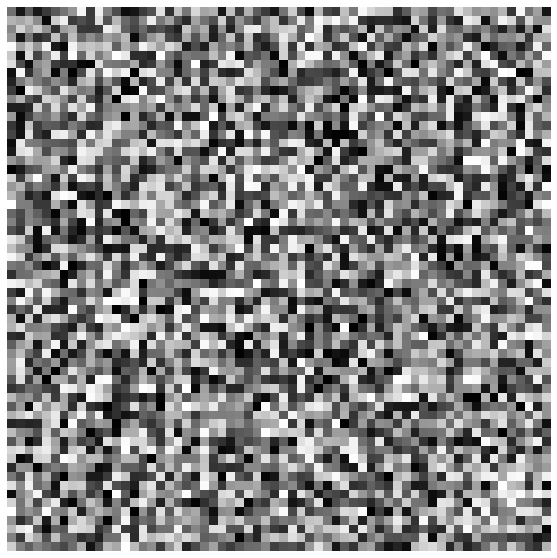

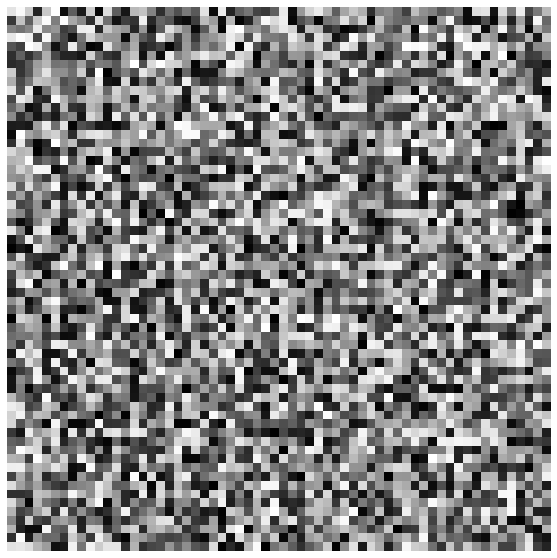

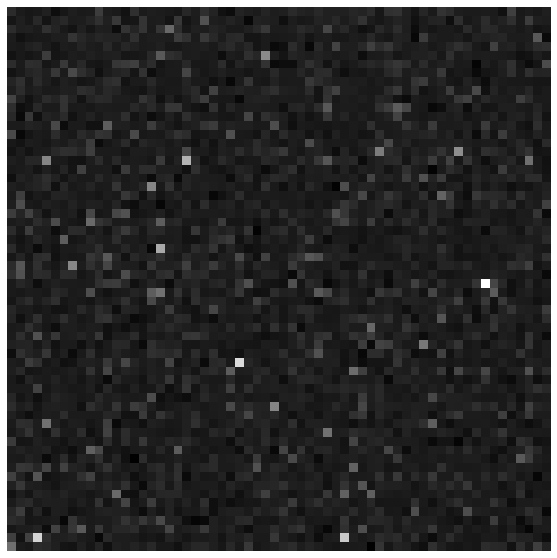

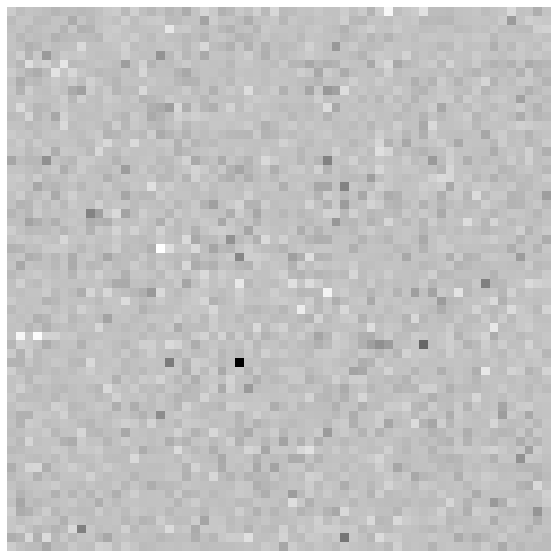

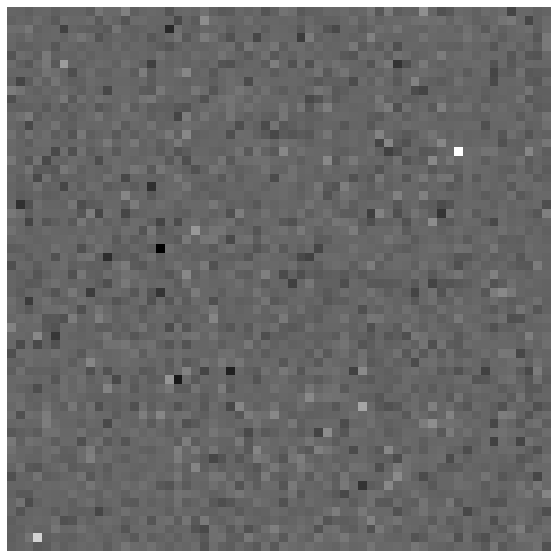

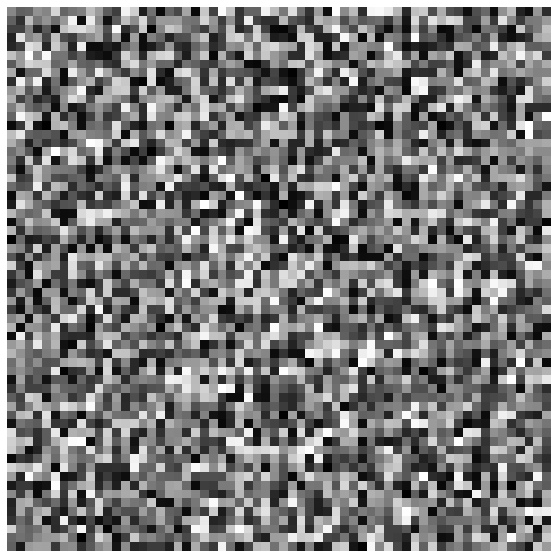

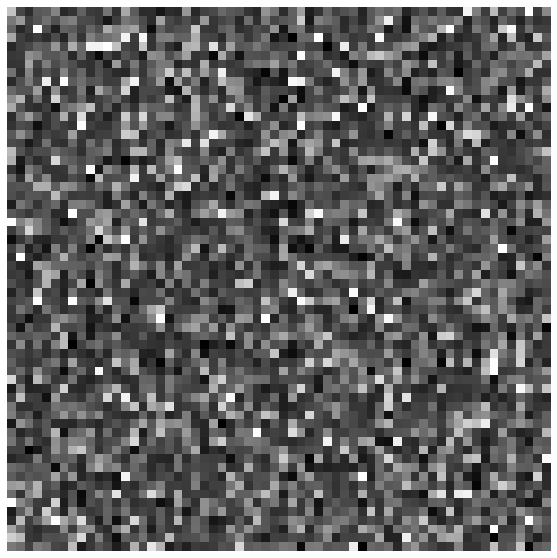

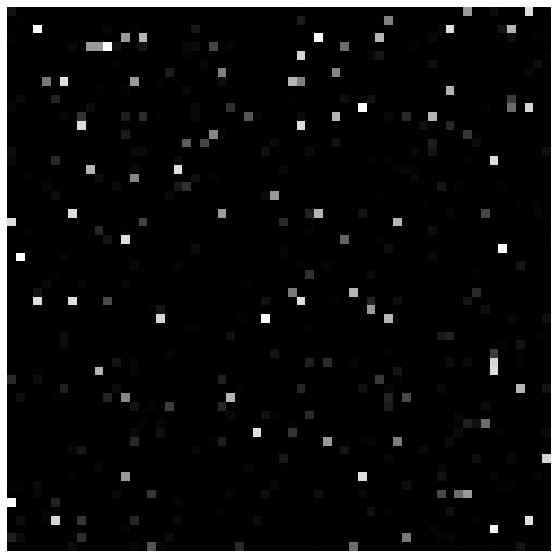

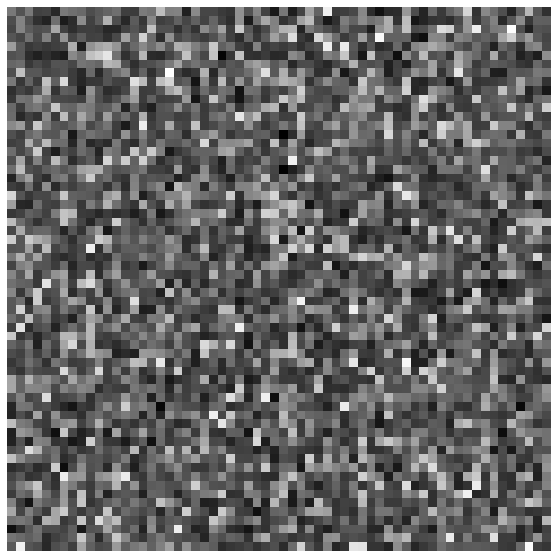

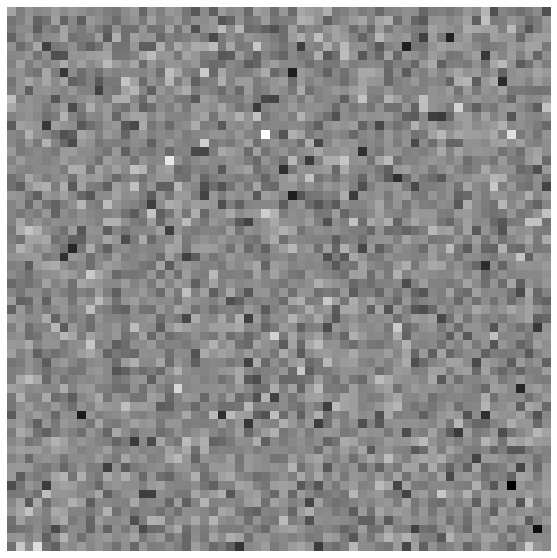

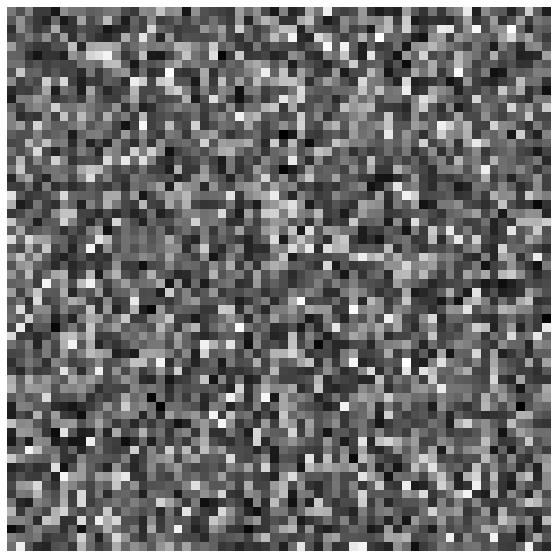

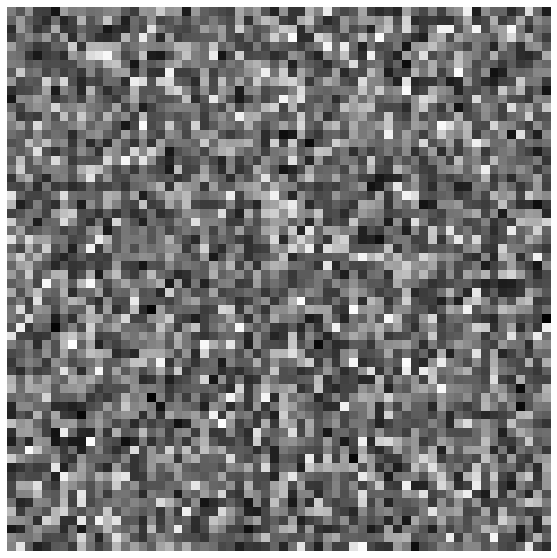

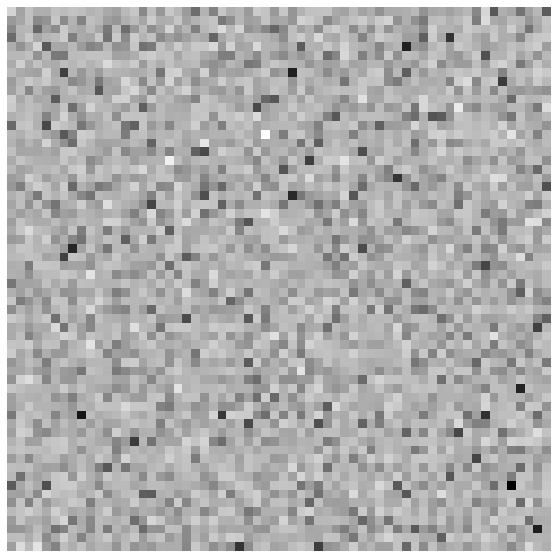

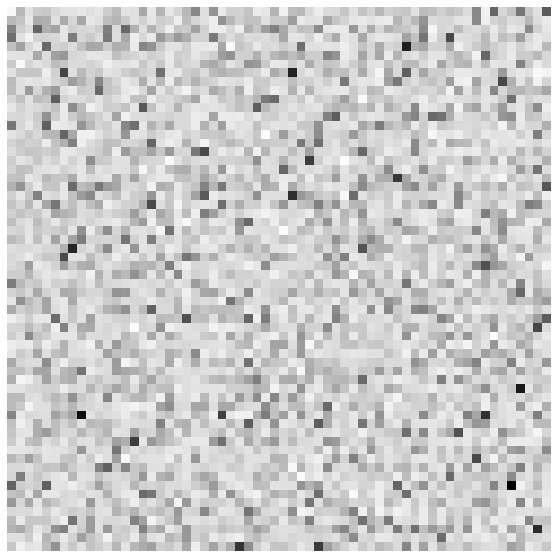

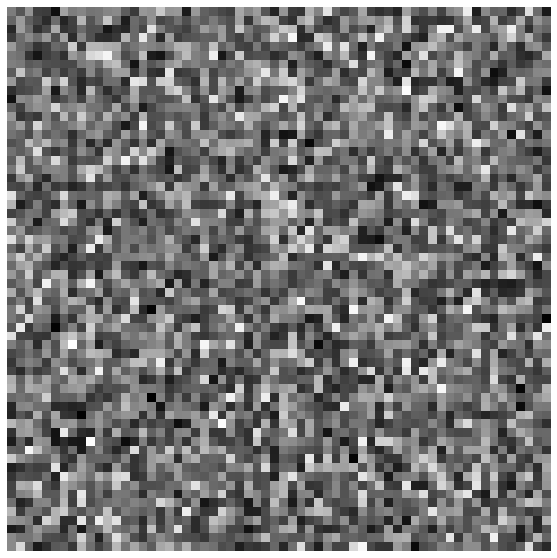

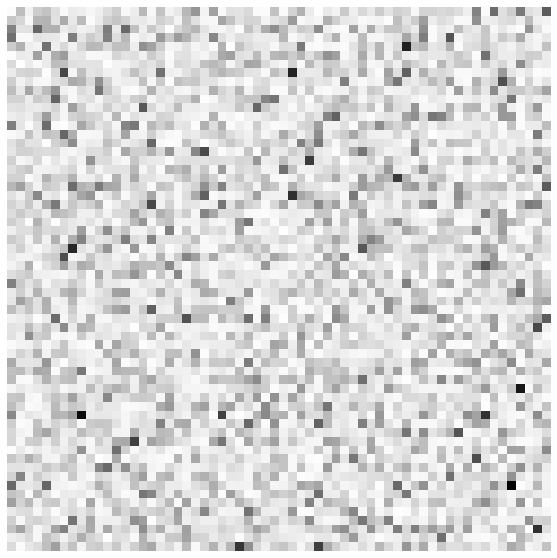

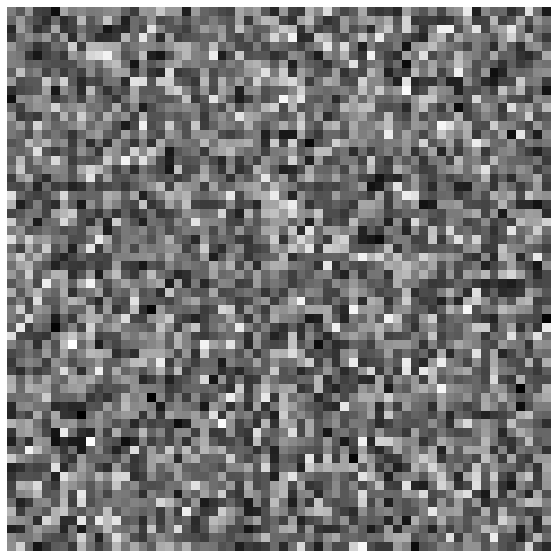

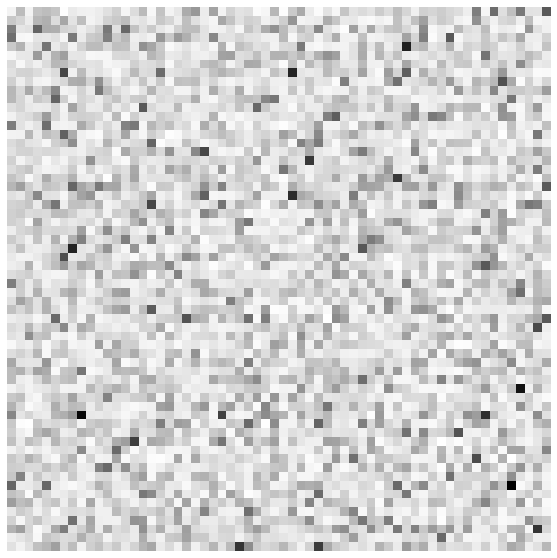

In [3]:
for i in range(0,18) :
    displayData(data[0:3844,i])

What this function does is simple, it represents a number of points from the dataset as black and white pixels with the intensity based on the value of the feature of this point. Here we've done it for every (18) fetaures of the dataset. As we can see there are no groupings and no similarities between the features. Given this dataset, it is impossible to identify the number of categories and even more impossible to predict wich individual will fit in one category.

# The Principal Component Analysis

Let's remove some dimension to have a better view on the dataset :

PCA()

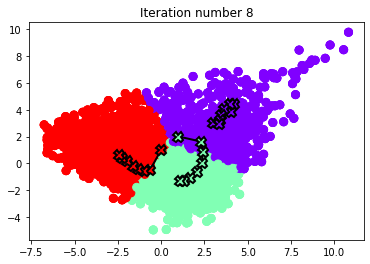

In [37]:
# We scale the value for a better analysis
scaler = StandardScaler()
data_std = scaler.fit_transform(data)
# We declare the sklearn version of the PCA 
pca = PCA()
pca.fit(data_std)

Now that the PCA is created, let see how the dataset is behaving. We will do that by analyzing the variance along each axis.

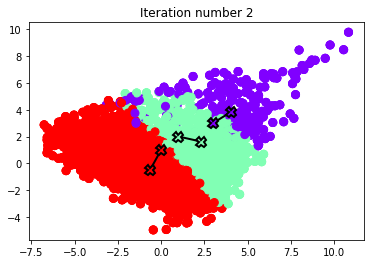

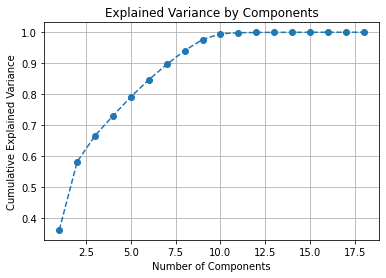

[0.36064194 0.58131413 0.66577574 0.7299054  0.79123592 0.84644261
 0.89580003 0.94063499 0.97636645 0.99501204 0.99838669 0.99921656
 0.99959834 0.99978948 0.99994918 0.99999772 0.999999   1.        ]


In [38]:
# Check how many componants we will need and how much they contribute
var_ratio = pca.explained_variance_ratio_
plt.figure()
plt.plot(range(1,len(var_ratio)+1),var_ratio.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()
print(var_ratio.cumsum())

We choose the number of component that yield 80% of explained variance : n_component = 5.
That will later on cause some problem when trying to plot the clusters along the axes, but with some tricks it will be possible to show these 5 dimensions.


In [17]:
# We can now chose the number of component in our PCA :

pca = PCA(n_components = 5)
pca.fit(data_std)
var_ratio_5 = pca.explained_variance_ratio_
print(f'The ratio of variance along the 5 principal axes are : {var_ratio_5}')

The ratio of variance along the 5 principal axis are : [0.36064194 0.22067219 0.08446161 0.06412966 0.06133052]


The last component, the one that won't be clearly visible in the plot only represents 6% of the variance so we won't lose too much information.

In [24]:
# We can now calculate the resulting components scores for the elements in our data set
scores = pca.transform(data_std)
Y = pca.components_


Now now we're done reducing the dimensionality of the dataset, let's do the clustering. 
First we have to estimate the number of cluster of the dataset. We can use either the Kaiser rule (https://towardsdatascience.com/k-means-clustering-one-rule-to-group-them-all-f47e00720ee7) or the Elbow rule which is more empirical (https://en.wikipedia.org/wiki/Elbow_method_(clustering))



In [26]:
# For the Kaiser rule, you need the principal components
def kaiser_rule(M):
    _, S, _ = np.linalg.svd(M)
    k = np.min(np.where(S<1))
    return k

k = kaiser_rule(Y) 
print(f'According to the Kaiser rule, there are {k} clusters in this dataset')

According to the Kaiser rule, there are 2 clusters in this dataset


Rq : the Kaiser rule gives different result everytime you run it and we don't know why (possible outcome are 0(???), 1, 2, 3 and 4). For the remaining operations, we will assume the result k = 2, the most frequent result.

And the second method :

100%|██████████| 15/15 [00:01<00:00,  7.78it/s]


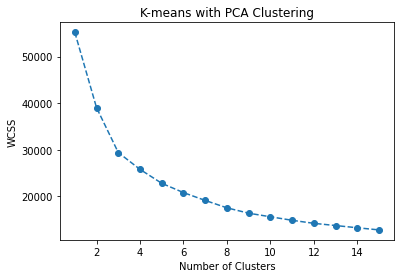

In [20]:
# Now with the Elbow rule (with a maximum of 15 clusters)
WCSS = []
for i in tqdm(range(1,16)):
    kmeans_pca = KMeans(n_clusters = i, init  ='k-means++', random_state = 42).fit(scores)
    WCSS.append(kmeans_pca.inertia_)

plt.figure()
plt.plot(range(1,16), WCSS, marker = 'o', linestyle = '--')
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.title('K-means with PCA Clustering')
plt.show()

With this method(which gives the same graph everytime) 3 clusters seems a good choice. As 4 could also be chosen with this method, we will take the middle value of all these results : k = 3


In [27]:
k = 3

# The Clustering

We will do the clustering of the dataset using the Kmeans clustering technique from the library Scikit-learn

In [28]:
kmeans = KMeans(n_clusters = k, random_state = 0).fit(scores)

# We can now determine the category of each point of the dataset using the label command
labels = kmeans.labels_
# And the centroids of each cluster
centroids = kmeans.cluster_centers_

To plot the result of our clustering, we need to divide every columns of the scores array into vectors that will represent the 5 directions.

C:\Users\julia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\matplotlib\collections.py:967: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


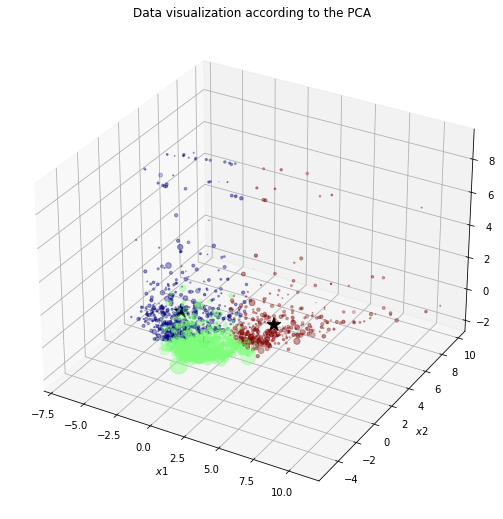

In [29]:
# x1, x2 and x3, the 3 principal components will be the xyz of our plot
x1, x2, x3 = scores[:,0], scores[:,1], scores[:,2]

# x4 and x5 will be shown as size and transparency of the dot
x4 = scores[:,3]

# We need to scale x5 into a value between 0 and one as required by the alpha coefficient in ax.scatter
x5 = (scores[:,4]-np.min(scores[:,4]))/(np.max(scores[:,4])-np.min(scores[:,4]))

c1, c2, c3 = centroids[:,0], centroids[:,1], centroids[:,2]


# 3D plotting 
fig = plt.figure(figsize = (9,9))
ax = fig.add_subplot(projection='3d')
ax.scatter(x1, x2, x3, alpha = x5, c = labels, s = 15*x4, marker = 'o', cmap='jet')  # 15 as an arbitrary factor otherwise the points are too small
ax.scatter(c1, c2, c3, marker='*', c='k', s=200, alpha = 1 )
ax.set_xlabel('$x1$')
ax.set_ylabel('$x2$')
ax.set_zlabel('$x3$')
plt.title("Data visualization according to the PCA")
plt.grid(True)
plt.show()


We can clearly see the groupings with this amount of dimensions, the points creates 3 zones and their sizes correspond to these positions. However, the Z-axis has some variance that may be relevant but as whe chose to divide the dataset into 3 clusters, this variance is not enough to be taken into account. If we change the number of clusters to 4, this is whaty we get :

C:\Users\julia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\matplotlib\collections.py:967: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


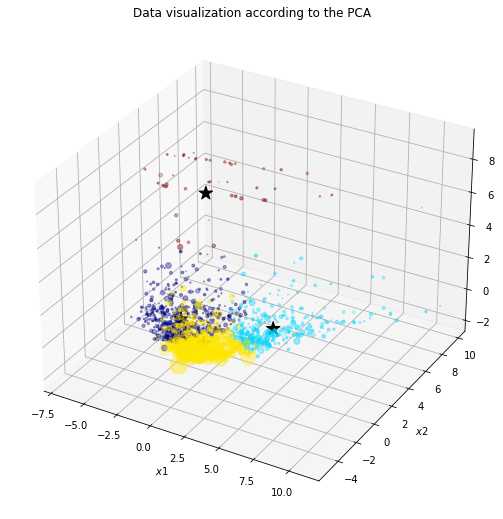

In [30]:
kmeans = KMeans(n_clusters = 4, random_state = 0).fit(scores)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

c1, c2, c3 = centroids[:,0], centroids[:,1], centroids[:,2]


fig = plt.figure(figsize = (9,9))
ax = fig.add_subplot(projection='3d')
ax.scatter(x1, x2, x3, alpha = x5, c = labels, s = 15*x4, marker = 'o', cmap='jet')
ax.scatter(c1, c2, c3, marker = '*', c = 'k', s = 200, alpha = 1 )
ax.set_xlabel('$x1$')
ax.set_ylabel('$x2$')
ax.set_zlabel('$x3$')
plt.title("Data visualization according to the PCA")
plt.grid(True)
plt.show()

We see that it's not a bad thing (a priori) to consider 4 clusters, as the one above the plane are in the same cluster. We will evaluate it later, but beforehand, let's also consider 2 clusters, as said by the Kaiser rule :

C:\Users\julia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\matplotlib\collections.py:967: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


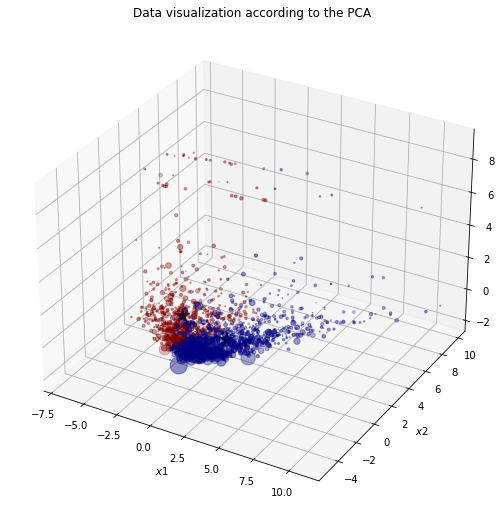

In [31]:
kmeans = KMeans(n_clusters = 2, random_state = 0).fit(scores)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

c1, c2, c3 = centroids[:,0], centroids[:,1], centroids[:,2]


fig = plt.figure(figsize = (9,9))
ax = fig.add_subplot(projection='3d')
ax.scatter(x1, x2, x3, alpha = x5, c = labels, s = 15*x4, marker = 'o', cmap='jet')
ax.scatter(c1, c2, c3, marker = '*', c = 'k', s = 200, alpha = 1 )
ax.set_xlabel('$x1$')
ax.set_ylabel('$x2$')
ax.set_zlabel('$x3$')
plt.title("Data visualization according to the PCA")
plt.grid(True)
plt.show()


This one, despite being the result of an analytical method, doesn't feel right.

Let's use a method called the Silhouette Analysis (https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a) to evaluate again the number of clusters 

Score for 2 clusters : 0.27888971391539835
Score for 3 clusters : 0.29743611776582596
Score for 4 clusters : 0.30293132898669567


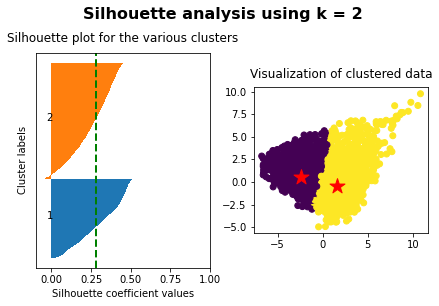

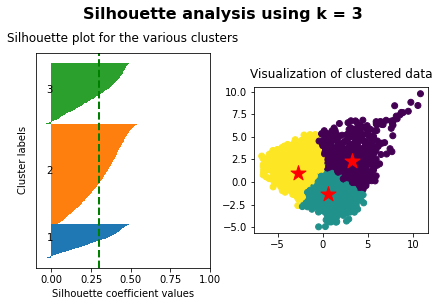

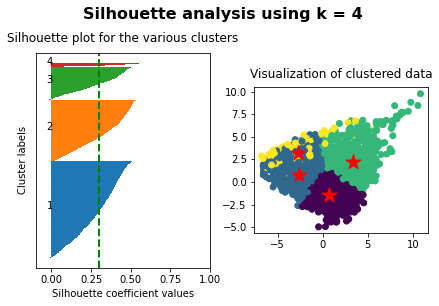

In [32]:
for i, k in enumerate([2, 3, 4]):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(scores)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(scores, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)
    
    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    print(f'Score for {k} clusters : {avg_score}')
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);
    
    # Scatter plot of data colored with labels
    ax2.scatter(scores[:, 0], scores[:, 1], c=labels)
    ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
    ax2.set_title('Visualization of clustered data', y=1.02)
    ax2.set_aspect('equal')
    plt.tight_layout()
    plt.suptitle(f'Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05);

In our case, this method gives the same score for 2, 3 or 4 clusters, that may be why with the Kaiser rule and the Elbow method we found these results, they all carry the same amount of information.

We will keep k = 3


As a visualization of the clustering algorithm, we can plot the evolution of the clusters and their centroids.

In [33]:
def kMeansInitCentroids(X, K):
    #we define the starting centroids for the clusters (chosen randomly)
    m,n = np.shape(X)
    initcentroids = np.random.randint(min(X[0,:]), max(X[0,:]),K*n).reshape((K,n))
    return initcentroids

def findClosestCentroids(X, centroids):
    m,n = np.shape(X)
    # Set the number of clusters
    K = centroids.shape[0]
    # The centroids are in the following variable
    closest_centroid = []
    
    #for each point of the dataset
    for i in range(m):
        #we generate a list of distance between the point m and the different centroids
        dist_list = []
        for centre in range(K) :
            #we compute the euclidian norm
            dist = np.linalg.norm(X[i,:]-centroids[centre,:])
            dist_list.append(dist)
        #we assign the closest centroid
        closest_centroid.append(dist_list.index(min(dist_list)))
    
    return np.array(closest_centroid)

def new_centroids(X, closest_centroid, K):
    m, n = X.shape
    # The centroids are in the following variable
    centroids = np.zeros((K, n))

    for k in range(K):
        centroids[k,:] = np.mean(X[closest_centroid == k,:], axis = 0)

    return centroids

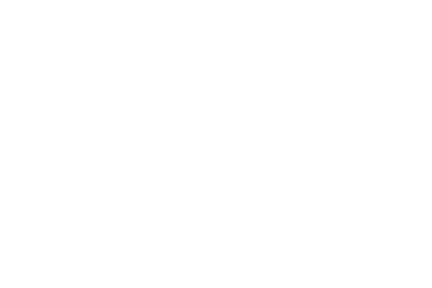

In [34]:
%matplotlib widget

# Settings for running K-Means
K = 3
max_iters = 10

# For consistency, here we set centroids to specific values
# but in practice you want to generate them automatically, such as by
# settings them to be random examples (as can be seen in
# kMeansInitCentroids).
initial_centroids = np.array([[3, 3,3], [1, 2, 1], [0, 1, 0]])


# Run K-Means algorithm. The 'true' at the end tells our function to plot
# the progress of K-Means

centroids, idx, anim = runkMeans(scores[:,0:3], initial_centroids,
                                       findClosestCentroids, new_centroids, max_iters, True)

anim
plt.show()

And finally, we can plot the planes and their  category on a graph (assuming that the two first feature are the longitude and latitude)

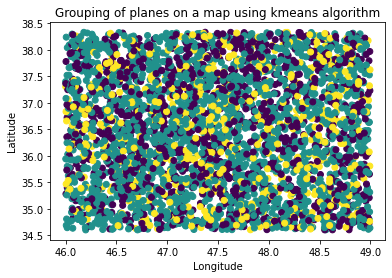

In [35]:
%matplotlib inline

x, y = data[:,0], data[:,1]

kmeans = KMeans(n_clusters = 3, random_state = 0).fit(scores)
labels = kmeans.labels_
plt.scatter(x, y, c = labels)
plt.title("Grouping of planes on a map using kmeans algorithm")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# Conclusion

We've seen in this project that it is possible to estimate groupings, and even represents them, despite having an original dataset of many dimensions with no clear distinction between the individuals. We are able to keep a lot of information even by removing more than 2/3 of the original axes. We could even have more variance than what we currently have by adding more than 5 axes on our PCA, but there could not be a graphic representation. This could be used in the case where we want to predict the category of a new plane. for this usage, 9 axes would yield 97.8% of variance and would ensure a good prediction while reducing the size of the set by half.